In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [29]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download suneelreddy696699/images-for-sih

Dataset URL: https://www.kaggle.com/datasets/suneelreddy696699/images-for-sih
License(s): other
100% 1.99G/1.99G [01:06<00:00, 79.4MB/s]
100% 1.99G/1.99G [01:06<00:00, 32.1MB/s]


In [ ]:
!unzip images-for-sih.zip -d ./images-for-sih


Streaming output truncated to the last 5000 lines.
  inflating: ./images-for-sih/Dataset/images/image-4366.png  
  inflating: ./images-for-sih/Dataset/images/image-4367.png  
  inflating: ./images-for-sih/Dataset/images/image-4368.png  
  inflating: ./images-for-sih/Dataset/images/image-4369.png  
  inflating: ./images-for-sih/Dataset/images/image-437.png  
  inflating: ./images-for-sih/Dataset/images/image-4370.png  
  inflating: ./images-for-sih/Dataset/images/image-4371.png  
  inflating: ./images-for-sih/Dataset/images/image-4372.png  
  inflating: ./images-for-sih/Dataset/images/image-4373.png  
  inflating: ./images-for-sih/Dataset/images/image-4374.png  
  inflating: ./images-for-sih/Dataset/images/image-4375.png  
  inflating: ./images-for-sih/Dataset/images/image-4376.png  
  inflating: ./images-for-sih/Dataset/images/image-4377.png  
  inflating: ./images-for-sih/Dataset/images/image-4378.png  
  inflating: ./images-for-sih/Dataset/images/image-4379.png  
  inflating: ./image

In [ ]:
#importing tyhe necessary libraries
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image

print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [ ]:
#chatgpt generated for the shoadow effect in the images
import numpy as np
class AddBlackShadow:
    def __init__(self, shadow_factor_range=(0.1, 0.3), shadow_area=(0.5, 1.0)):
        """
        Args:
            shadow_factor_range: Tuple specifying the range of shadow intensity (0 = black, 1 = no change).
            shadow_area: Tuple specifying the proportion of the image to apply the shadow (e.g., 0.5 to 1.0).
        """
        self.shadow_factor_range = shadow_factor_range
        self.shadow_area = shadow_area

    def __call__(self, img):
        # Ensure input is a PIL image
        if not isinstance(img, Image.Image):
            raise TypeError(f"Expected input to be a PIL.Image, got {type(img)}")

        # Convert image to a NumPy array for pixel manipulation
        img_np = np.array(img)

        # Generate random shadow factor
        shadow_factor = random.uniform(*self.shadow_factor_range)

        # Generate random region for the shadow
        height, width, _ = img_np.shape
        shadow_height = int(height * random.uniform(*self.shadow_area))
        shadow_start = random.randint(0, height - shadow_height)

        # Apply shadow to the selected region
        img_np[shadow_start:shadow_start + shadow_height, :, :] = (
            img_np[shadow_start:shadow_start + shadow_height, :, :] * shadow_factor
        ).astype(np.uint8)

        # Convert back to PIL image
        return Image.fromarray(img_np)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random
import os

#paths to the image files
noisy_folder = "/content/images-for-sih/Dataset/Noisy"
clean_folder = "/content/images-for-sih/Dataset/images"

#file names inside the dirs
noisy_files = sorted(os.listdir(noisy_folder))
clean_files = sorted(os.listdir(clean_folder))

#creating the dataset
class ImagePairDataset(Dataset):
    def __init__(self, noisy_files, clean_files, noisy_folder, clean_folder, transform=None):
        self.noisy_files = noisy_files
        self.clean_files = clean_files
        self.noisy_folder = noisy_folder
        self.clean_folder = clean_folder
        self.transform = transform

    def __len__(self):
        return len(self.noisy_files)

    def __getitem__(self, idx):
        #loading the images
        noisy_path = os.path.join(self.noisy_folder, self.noisy_files[idx])
        clean_path = os.path.join(self.clean_folder, self.clean_files[idx])

        noisy_image = Image.open(noisy_path).convert('RGB')
        clean_image = Image.open(clean_path).convert('RGB')


        if self.transform:
            noisy_image = self.transform(noisy_image)

        clean_image = transforms.ToTensor()(clean_image)

        return noisy_image, clean_image
#transformation function for the augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    AddBlackShadow(shadow_factor_range=(0.2, 0.6), shadow_area=(0.3, 0.7)),
    transforms.ToTensor()  # Convert to tensor
])
#Creating the dataset
dataset = ImagePairDataset(noisy_files, clean_files, noisy_folder, clean_folder, transform)



In [ ]:
import random


In [ ]:
image,label=dataset[0]

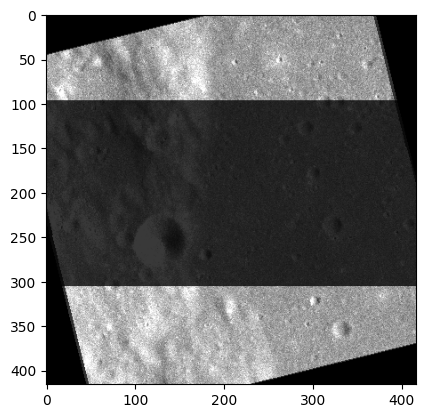

In [ ]:
transposed_image = image.permute(1, 2, 0)
transposed_noisy=label.permute(1,2,0)
plt.imshow(transposed_image)
#plt.imshow(transposed_noisy)

In [ ]:
type(dataset)

__main__.ImagePairDataset

In [ ]:
len(dataset)

8741

In [39]:
from torch.utils.data import random_split

#Sizes
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing

#Splitting the data
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#Data loader for the training and the testing
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
test_loader.dataset

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#Model Architecture
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        #Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        #self.enc4 = self.conv_block(256, 512)


        self.bottleneck = self.conv_block(256, 512)

        #Decoder
        self.upconv4 = self.upconv_block(512, 256)
        self.upconv3 = self.upconv_block(256, 128)
        self.upconv2 = self.upconv_block(128, 64)
        #self.upconv1 = self.upconv_block(128, 64)

        #Final output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def upconv_block(self, in_channels, out_channels):

        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        # Encoder path
        enc1_out = self.enc1(x)
        enc2_out = self.enc2(enc1_out)
        enc3_out = self.enc3(enc2_out)
        enc4_out = self.enc4(enc3_out)


        bottleneck_out = self.bottleneck(enc4_out)

        #Decoder path
        upconv4_out = self.upconv4(bottleneck_out)
        upconv3_out = self.upconv3(upconv4_out + enc4_out)  # Skip connection
        upconv2_out = self.upconv2(upconv3_out + enc3_out)
        upconv1_out = self.upconv1(upconv2_out + enc2_out)

        #output layer
        output = self.final_conv(upconv1_out + enc1_out)

        return output





In [44]:
1024/512

2.0

In [51]:
model_0 = UNet(in_channels=3, out_channels=3) #you can keep tyhe outchannels as usual or change to tyhe gray images and you need to change the labels also if you want to change into tyhe gray images

In [47]:
model_0.to(device)

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  

In [48]:
#loss function and the optimizer change them as you like and experiment
from torch import optim
loss_fn=nn.MSELoss()
optimizer=optim.Adam(params=model_0.parameters(),lr=0.001)

In [49]:
def accuracy(y_true, preds):
    preds = preds.to(y_true.device)
    correct = (preds == y_true).sum().item()
    total = len(y_true)
    return 100 * correct / total

In [50]:
from tqdm.auto import tqdm
import torch

torch.manual_seed(42)
epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"\nEpoch {epoch+1}/{epochs}\n" + "-" * 20)

    #Training phase
    cumulative_train_loss, cumulative_train_acc = 0, 0
    model_0.train()
    for batch, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        #Forward pass
        Y_preds = model_0(images)
        loss = loss_fn(Y_preds, labels)

        #Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cumulative_train_loss += loss.item()
        cumulative_train_acc += accuracy(y_true=labels, preds=Y_preds.argmax(dim=1))

        if batch % 10 == 0:
            print(f"Batch {batch}: Processed {batch * len(images)}/{len(train_loader.dataset)} samples.")

    train_loss = cumulative_train_loss / len(train_loader)
    train_acc = cumulative_train_acc / len(train_loader)

    #Evaluation
    cumulative_test_loss, cumulative_test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, Y_test in test_loader:
            X_test, Y_test = X_test.to(device), Y_test.to(device)
            test_preds = model_0(X_test)

            #loss and the accuracy calculation
            loss = loss_fn(test_preds, Y_test)
            cumulative_test_loss += loss.item()
            cumulative_test_acc += accuracy(y_true=Y_test, preds=test_preds.argmax(dim=1))

    test_loss = cumulative_test_loss / len(test_loader)
    test_acc = cumulative_test_acc / len(test_loader)

    print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.2f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}")



  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1/5
--------------------


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 37.06 MiB is free. Process 55485 has 14.71 GiB memory in use. Of the allocated memory 14.57 GiB is allocated by PyTorch, and 18.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [42]:
!nvidia-smi


Fri Dec  6 16:16:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0              28W /  70W |  14999MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--